<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Process-CCSs" data-toc-modified-id="Process-CCSs-1">Process CCSs</a></span><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1.1">Setup</a></span></li><li><span><a href="#PacBio-amplicons" data-toc-modified-id="PacBio-amplicons-1.2">PacBio amplicons</a></span></li><li><span><a href="#CCS-stats-for-PacBio-runs" data-toc-modified-id="CCS-stats-for-PacBio-runs-1.3">CCS stats for PacBio runs</a></span></li><li><span><a href="#Align-CCSs-to-amplicons" data-toc-modified-id="Align-CCSs-to-amplicons-1.4">Align CCSs to amplicons</a></span></li><li><span><a href="#Write-valid-CCSs" data-toc-modified-id="Write-valid-CCSs-1.5">Write valid CCSs</a></span></li></ul></li></ul></div>

# Build Variants
This Python Jupyter notebook processes the nt-level barcode lookup table for the RsYN04 background to generate a protein-level barcode-variant lookup table and analyze mutation coverage.

## Setup

Import Python modules

Plotting is done with [plotnine](https://plotnine.readthedocs.io/en/stable/), which uses ggplot2-like syntax.

The analysis uses the Bloom lab's [alignparse](https://jbloomlab.github.io/alignparse) and [dms_variants](https://jbloomlab.github.io/dms_variants) packages.

In [1]:
import collections
import math
import os
import re
import time
import warnings

import alignparse
import alignparse.ccs
from alignparse.constants import CBPALETTE
import alignparse.minimap2
import alignparse.targets
import alignparse.consensus

import dms_variants
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.utils

from IPython.display import display, HTML

import numpy

import pandas as pd

from plotnine import *

import yaml


Define the background for variant mapping.

In [2]:
background = "RsYN04"

Set [plotnine](https://plotnine.readthedocs.io/en/stable/) theme to the one defined in [dms_variants](https://jbloomlab.github.io/dms_variants):

In [3]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [4]:
print(f"Using alignparse version {alignparse.__version__}")
print(f"Using dms_variants version {dms_variants.__version__}")

Using alignparse version 0.2.4
Using dms_variants version 0.8.9


Ignore warnings that clutter output:

In [5]:
warnings.simplefilter('ignore')

Read the configuration file:

In [6]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory for figures:

In [7]:
os.makedirs(config['figs_dir'], exist_ok=True)
os.makedirs(config['variants_dir'], exist_ok=True)

## Consensus sequences
Read the CSV file giving consensus sequences (in terms of nt mutations) and barcodes. Subset on the background analyzed in this notebook:

In [8]:
consensus = pd.read_csv(config['nt_variant_table_file'], na_filter=None)

consensus = consensus[consensus['target'] == background]
consensus = consensus[consensus['library'] != "lib46"]

nlibs = consensus['library'].nunique()  # number of unique libraries

ntargets = consensus['target'].nunique()  # number of unique targets

print(f"Read {len(consensus)} consensus sequences from {nlibs} libraries and {ntargets} targets.")

#output bg-specific nt table for reading in as codon variant table
(consensus
 [['target', 'library', 'barcode', 'substitutions', 'variant_call_support','number_of_indels']]
 .to_csv(config['nt_variant_table_file_' + background], index=False)
 )


Read 74068 consensus sequences from 2 libraries and 1 targets.


## Create barcode-variant table
We now create a [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) that stores and processes all the information about the variant consensus sequences.
Below we initialize such a table, and then analyze information about its composition.

### Initialize codon variant table
In order to initialize the codon variant table, we need two pieces of information:
  1. The wildtype gene sequence.
  2. The list of nucleotide mutations for each variant as determined in the consensus calling above.

Read "wildtype" gene sequence to which we made the alignments (in order to do this, initialize an `alignparse.Targets` and get the gene sequence from it):

In [9]:
targets = alignparse.targets.Targets(seqsfile=config['amplicons_' + background],
                                     feature_parse_specs=config['feature_parse_specs_' + background])
geneseq = targets.get_target(background).get_feature('gene').seq

print(f"Read gene of {len(geneseq)} nts for {background} from {config['amplicons_' + background]}")

Read gene of 591 nts for RsYN04 from data/PacBio_amplicon_RsYN04.gb


Now initialize the codon variant table using this wildtype sequence and our list of nucleotide mutations for each variant:

In [10]:
variants = dms_variants.codonvarianttable.CodonVariantTable(
                barcode_variant_file=config['nt_variant_table_file_' + background],
                geneseq=geneseq,
                primary_target=background,
                )

### Basic stats on variants
We now will analyze the variants.
In this call and in the plots below, we set `samples=None` as we aren't looking at variant counts in specific samples, but are simply looking at properties of the variants in the table.

Here are the number of variants for each target:

In [11]:
display(HTML(
    variants
    .n_variants_df(samples=None)
    .pivot_table(index=['target'],
                 columns='library',
                 values='count')
    .to_html()
    ))

library,lib40,lib41,all libraries
target,,,
RsYN04,35029,39039,74068


Plot the number of variants supported by each number of CCSs:

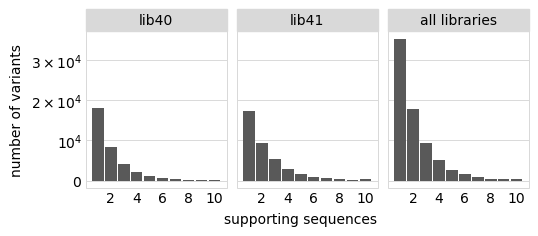

In [12]:
max_support = 10  # group variants with >= this much support

p = variants.plotVariantSupportHistogram(max_support=max_support,
                                         widthscale=1.1,
                                         heightscale=0.9)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

### Mutations per variant
Plot the number of barcoded variants with each number of amino-acid and codon mutations.
This is for the primary target only, and doesn't include the spiked-in secondary targets:

Saving plot to results/figures/n_aa_muts_per_variant_RsYN04.pdf
Saving plot to results/figures/n_codon_muts_per_variant_RsYN04.pdf


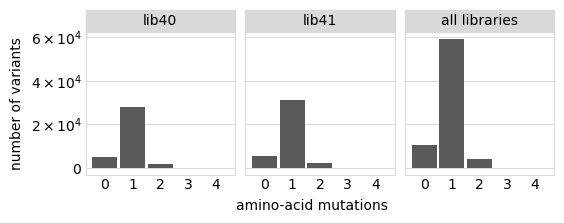

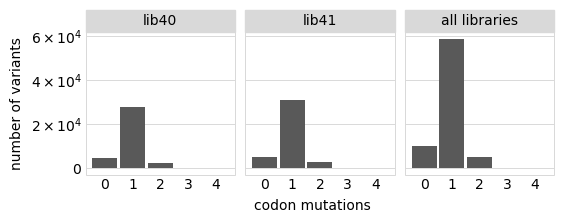

In [13]:
max_muts = 7  # group all variants with >= this many mutations

for mut_type in ['aa', 'codon']:
    p = variants.plotNumMutsHistogram(mut_type, samples=None, max_muts=max_muts,
                                      widthscale=1.1,
                                      heightscale=0.9)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw()
    plotfile = os.path.join(config['figs_dir'], f"n_{mut_type}_muts_per_variant_"+background+".pdf")
    print(f"Saving plot to {plotfile}")
    p.save(plotfile)

Plot the frequencies of different codon mutation types among **all** variants (any number of mutations), again only for primary target:

Saving plot to results/figures/avg_muts_per_variant_RsYN04.pdf


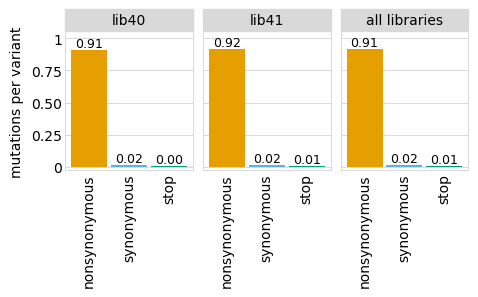

In [14]:
p = variants.plotNumCodonMutsByType(variant_type='all', samples=None,
                                    ylabel='mutations per variant',
                                    heightscale=0.8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()
plotfile = os.path.join(config['figs_dir'], f"avg_muts_per_variant_"+background+".pdf")
print(f"Saving plot to {plotfile}")
p.save(plotfile)

Variants supported by multiple PacBio CCSs should have fewer spurious mutations since sequencing errors are very unlikely to occur on two CCSs.
Below we plot the number of codon mutations per variant among variants with at least two CCSs supporting their call.
The difference in mutation rates here and in the plot above (that does not apply the `min_support=2` filter) gives some estimate of the frequency of mutations in our variants our spurious.
In fact, we see the numbers are very similar, indicating that few of the mutations are spurious:

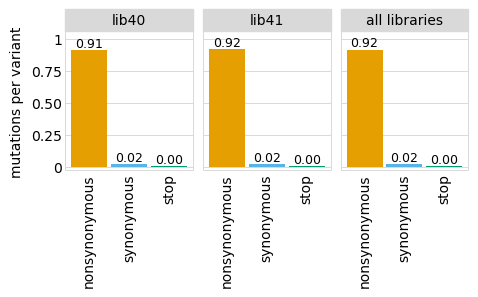

In [15]:
p = variants.plotNumCodonMutsByType(variant_type='all', samples=None,
                                    ylabel='mutations per variant', 
                                    min_support=2, heightscale=0.8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

### Completeness of mutation sampling
We examine how completely amino-acid mutations are sampled by the variants for the primary target, looking at single-mutant variants only and all variants.
The plot below shows that virtually every mutation is found in a variant in each library, even if we just look among the single mutants.
Things look especially good if we aggregate across libraries:

Saving plot to results/figures/variant_cumul_all_mut_coverage_RsYN04.pdf
Saving plot to results/figures/variant_cumul_single_mut_coverage_RsYN04.pdf


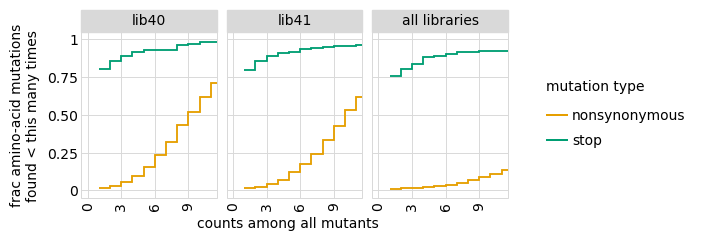

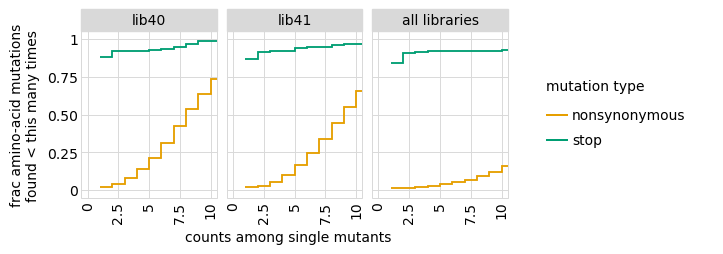

In [16]:
for variant_type in ['all', 'single']:
    p = variants.plotCumulMutCoverage(variant_type, mut_type='aa', samples=None)
    _ = p.draw()
    plotfile = os.path.join(config['figs_dir'],
                            f"variant_cumul_{variant_type}_mut_coverage_"+background+".pdf")
    print(f"Saving plot to {plotfile}")
    p.save(plotfile)

To get more quantitative information like that plotted above, we determine how many mutations are found 0, 1, or >1 times both among single and all mutants for the primary target:

In [17]:
count_dfs = []
for variant_type in ['all', 'single']:
    i_counts = (variants.mutCounts(variant_type, mut_type='aa', samples=None)
                .assign(variant_type=variant_type)
                )
    count_dfs += [i_counts.assign(include_stops=True),
                  i_counts
                  .query('not mutation.str.contains("\*")', engine='python')
                  .assign(include_stops=False)
                  ]
    
display(HTML(
    pd.concat(count_dfs)
    .assign(count=lambda x: (numpy.clip(x['count'], None, 2)
                             .map({0: '0', 1: '1', 2:'>1'}))
            )
    .groupby(['variant_type', 'include_stops', 'library', 'count'])
    .aggregate(number_of_mutations=pd.NamedAgg(column='mutation', aggfunc='count'))
    .to_html()
    ))

### Mutation frequencies along gene
We plot the frequencies of mutations along the gene among the variants for the primary target.
Ideally, this would be uniform.
We make the plot for both all variants and single-mutant / wildtype variants:

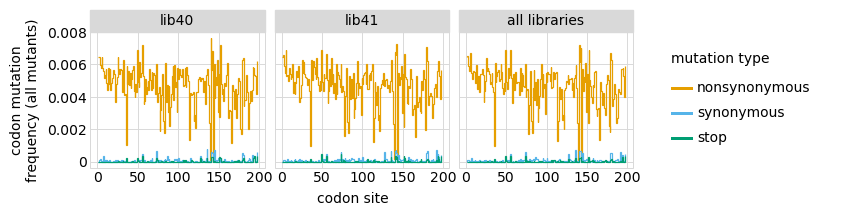

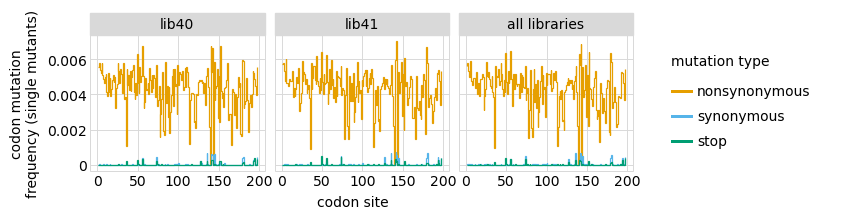

In [18]:
for variant_type in ['all', 'single']:
    p = variants.plotMutFreqs(variant_type, mut_type='codon', samples=None)
    p.draw()

We can also use heat maps to examine the extent to which specific amino-acid or codon mutations are over-represented.
These heat maps are large, so we make them just for all variants and the merge of all libraries:

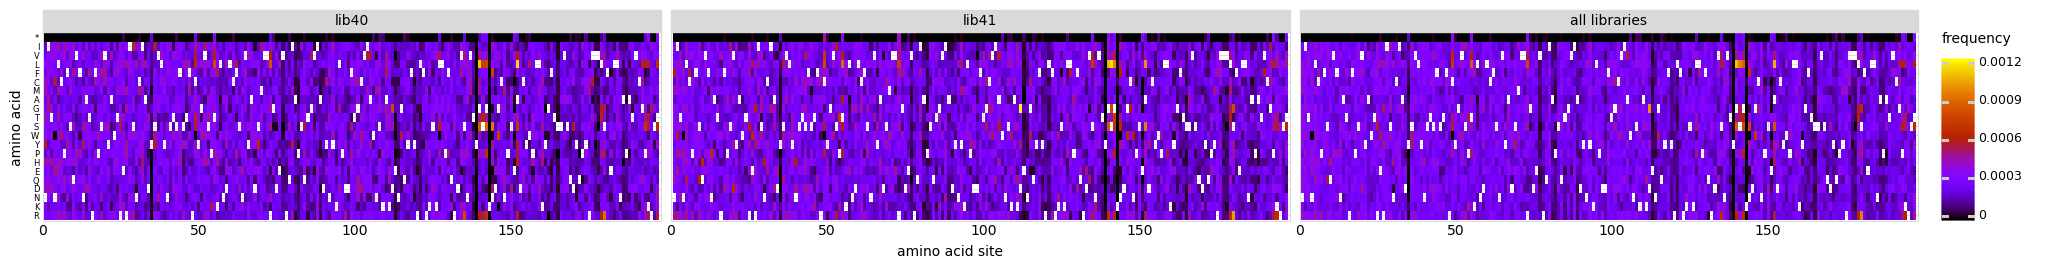

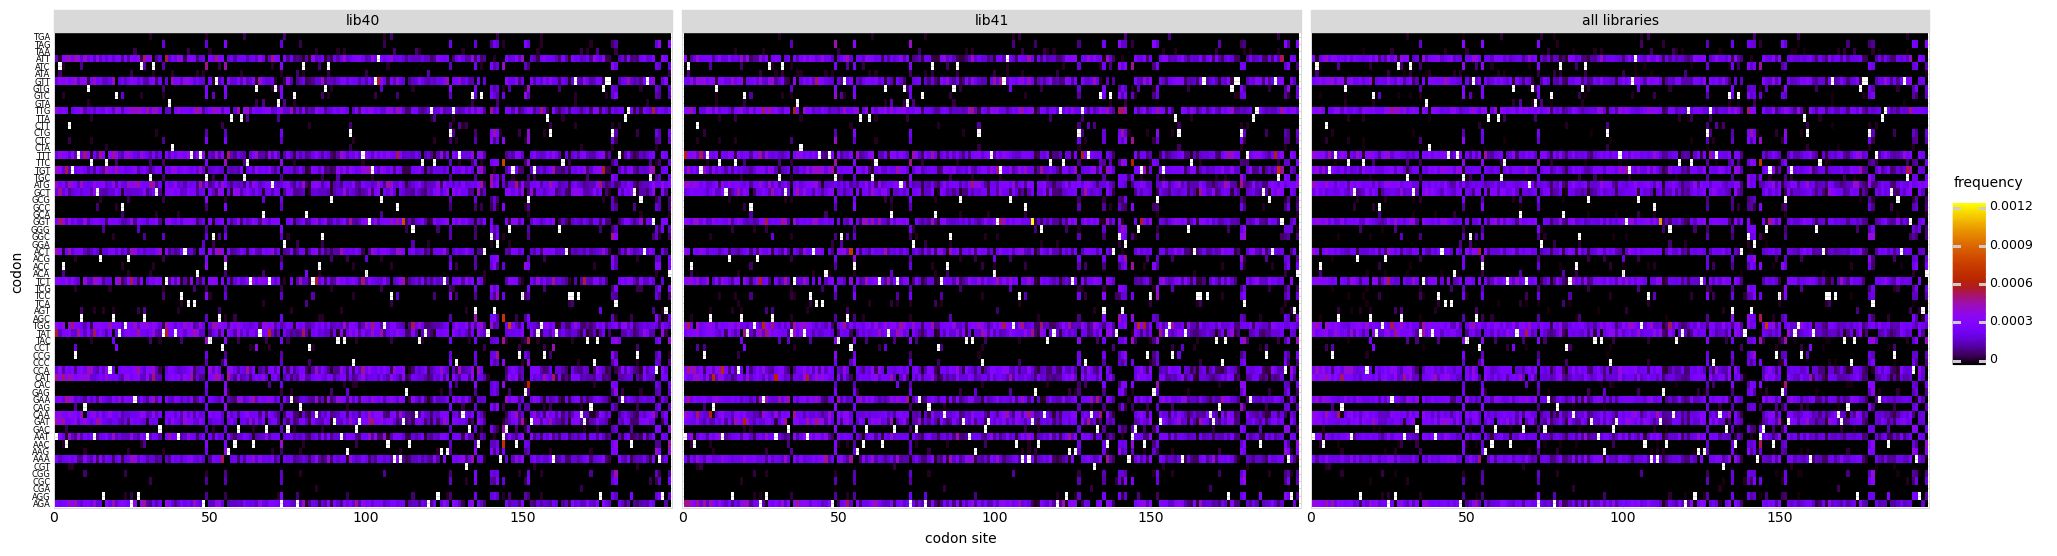

In [19]:
for mut_type in ['aa', 'codon']:
    p = variants.plotMutHeatmap('all', mut_type, samples=None, #libraries='all_only',
                                widthscale=2)
    p.draw()

### Write codon-variant table
We write the codon variant table to a CSV file.
This table looks like this:

In [20]:
display(HTML(
    variants.barcode_variant_df
    .head()
    .to_html(index=False)
    ))

target,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
RsYN04,lib40,AAAAAAAAACACTATG,1,GGC86TTT,G86F,1,1
RsYN04,lib40,AAAAAAAAATAAACGA,1,GTC20TTG,V20L,1,1
RsYN04,lib40,AAAAAAAACAGATATG,2,AAG56ACT,K56T,1,1
RsYN04,lib40,AAAAAAAAGAAAGAAT,1,GTT190ACT,V190T,1,1
RsYN04,lib40,AAAAAAAATGTGGATT,2,ATC2TGG,I2W,1,1


Note how this table differs from the nucleotide variant table we generated above and used to initialize the [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) in that it gives **codon** substitutions and associated amino-acid substitutions.

Write it to CSV file:

In [21]:
print(f"Writing codon-variant table to {config['codon_variant_table_file_'+background]}")

variants.barcode_variant_df.to_csv(config['codon_variant_table_file_'+background], index=False)

Writing codon-variant table to results/variants/codon_variant_table_RsYN04.csv
